# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [ ]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

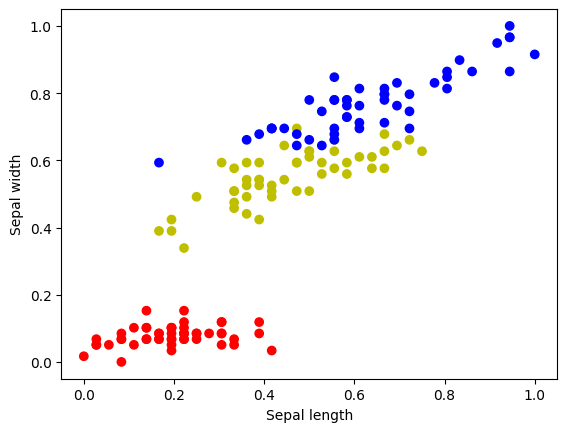

In [ ]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [ ]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [ ]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [ ]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [ ]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.3362, -0.6610],
                      [ 0.0729,  0.4675],
                      [ 0.6571,  0.6558]])),
             ('bias', tensor([-0.4907,  0.0626,  0.2022]))])

### Fazendo um predict

In [ ]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.6102,  0.1105,  0.3927],
        [-0.5915,  0.1065,  0.3562],
        [-0.5617,  0.0945,  0.3086],
        [-0.5747,  0.1083,  0.3126]], grad_fn=<AddmmBackward0>)

In [ ]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.1729, 0.3556, 0.4715],
        [0.1789, 0.3595, 0.4615],
        [0.1882, 0.3626, 0.4492],
        [0.1849, 0.3661, 0.4490]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [ ]:
F.softmax(out,dim=1)*100

tensor([[17.2947, 35.5562, 47.1490],
        [17.8905, 35.9546, 46.1549],
        [18.8154, 36.2634, 44.9212],
        [18.4898, 36.6072, 44.9029]], grad_fn=<MulBackward0>)

### Predição da classe

In [ ]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([2, 2, 2, 2])
tensor([0.4715, 0.4615, 0.4492, 0.4490], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [ ]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.20691440999507904


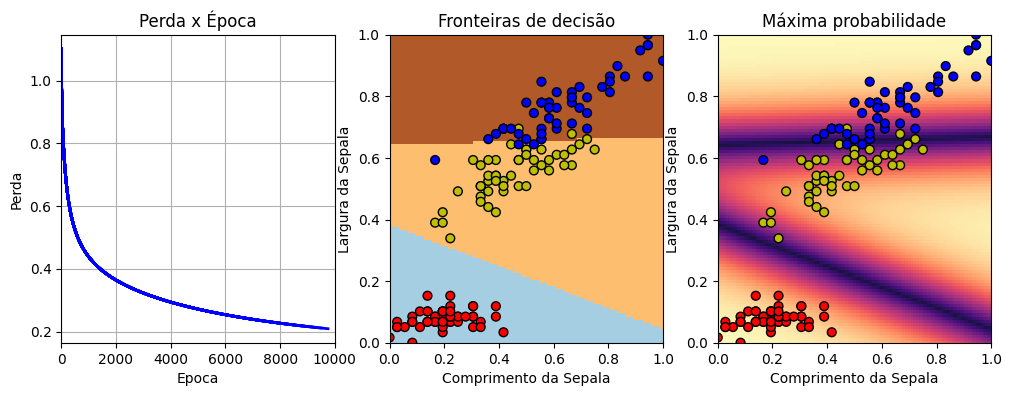

In [ ]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [ ]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.8652, -14.5674],
                      [  1.8795,  -0.5109],
                      [  1.3795,  15.5406]])),
             ('bias', tensor([ 6.9288,  1.5552, -8.7097]))])

### Salvando os parâmetros treinados

In [ ]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [ ]:
! ls ../models/

RegrLog_Iris.pt


In [ ]:
nn.init.constant(model.weight,0)
model.state_dict()

/tmp/ipython-input-952960416.py:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 6.9288,  1.5552, -8.7097]))])

### Recuperando os pesos salvos

In [ ]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

OrderedDict([('weight',
              tensor([[ -2.8652, -14.5674],
                      [  1.8795,  -0.5109],
                      [  1.3795,  15.5406]])),
             ('bias', tensor([ 6.9288,  1.5552, -8.7097]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [ ]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


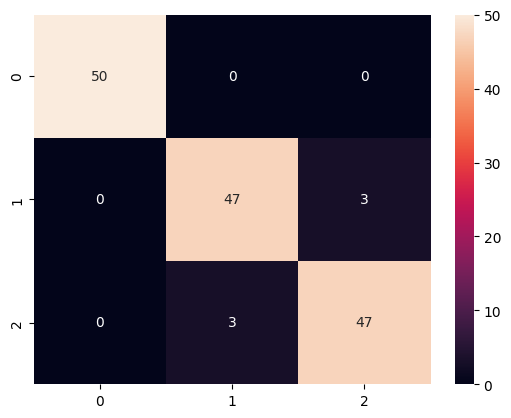

In [ ]:
# plotagem gráfico matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(Y, Y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

2. Experimente refazer o treinamento com diferentes valores de learning rate

**Respostas**

**1** - Para que o modelo comece o treinamento desde o início é necessário, reinstanciá-lo, criando-o novamente antes do laço de treinamento.

Ex.:

>  model = nn.Linear(2,3)

> optimizer = torch.optim.SGD(model.parameters(), lr=lr)





In [ ]:
# Lista de learning rates para testar
learning_rates = [0.001, 0.01, 0.1, 0.5]

num_epochs = 10000

# Para armazenar os resultados
results = {}

for lr in learning_rates:
    print(f"\n===== Treinando com learning rate = {lr} =====")

    # 1. Recriar o modelo do zero
    model = nn.Linear(2,3)

    # 2. Otimizador com o LR atual
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # 3. Lista para guardar o loss ao longo das épocas
    loss_history = []

    # 4. Loop de treinamento
    for epoch in range(num_epochs):
        # Forward
        logits = model(X_tensor)

        # Calcula a perda
        loss = criterion(logits, Y_tensor)

        # Zera gradientes
        optimizer.zero_grad()

        # Backprop
        loss.backward()

        # Atualiza pesos
        optimizer.step()

        # Guarda loss
        loss_history.append(loss.item())

        # Print opcional
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss.item():.4f}")

    # Salvar resultado do modelo naquele LR
    with torch.no_grad():
        preds = torch.argmax(model(X_tensor), dim=1)
        accuracy = (preds == Y_tensor).float().mean()

    results[lr] = {
        "model": model,
        "loss_history": loss_history,
        "accuracy": accuracy
    }

    print(f"Acurácia final com LR = {lr}: {accuracy:.4f}")
    # Exibir todos os LR e as acurácias
    for lr, result in results.items():
        print(f"LR: {lr}, Acurácia: {result['accuracy']:.4f}")


===== Treinando com learning rate = 0.001 =====
Epoch 50/10000 - Loss: 1.1644
Epoch 100/10000 - Loss: 1.1596
Epoch 150/10000 - Loss: 1.1550
Epoch 200/10000 - Loss: 1.1506
Epoch 250/10000 - Loss: 1.1464
Epoch 300/10000 - Loss: 1.1423
Epoch 350/10000 - Loss: 1.1383
Epoch 400/10000 - Loss: 1.1345
Epoch 450/10000 - Loss: 1.1308
Epoch 500/10000 - Loss: 1.1272
Epoch 550/10000 - Loss: 1.1237
Epoch 600/10000 - Loss: 1.1204
Epoch 650/10000 - Loss: 1.1171
Epoch 700/10000 - Loss: 1.1140
Epoch 750/10000 - Loss: 1.1109
Epoch 800/10000 - Loss: 1.1080
Epoch 850/10000 - Loss: 1.1051
Epoch 900/10000 - Loss: 1.1023
Epoch 950/10000 - Loss: 1.0996
Epoch 1000/10000 - Loss: 1.0969
Epoch 1050/10000 - Loss: 1.0944
Epoch 1100/10000 - Loss: 1.0919
Epoch 1150/10000 - Loss: 1.0894
Epoch 1200/10000 - Loss: 1.0870
Epoch 1250/10000 - Loss: 1.0847
Epoch 1300/10000 - Loss: 1.0824
Epoch 1350/10000 - Loss: 1.0802
Epoch 1400/10000 - Loss: 1.0780
Epoch 1450/10000 - Loss: 1.0759
Epoch 1500/10000 - Loss: 1.0738
Epoch 1550/

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?
    
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    
    3. Qual é a amostra classificada corretamente, com menor probabilidade?
    4. Qual é a amostra classificada erradamente, com menor probabilidade?
2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?
3. Quantas entradas e quantas saídas esta rede possui?
4. Como se pode calcular a acurácia a partir da matriz de confusão?
5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

**RESPOSTAS**

In [ ]:
# 1 -
# Forward com todas as amostras
out = model(X_tensor)

# Probabilidades
y_pred_probs = F.softmax(out, dim=1)

# Classes previstas
predicted_classes = torch.argmax(y_pred_probs, dim=1)
y_pred_class = predicted_classes        # tensor (150,)

# Rótulos verdadeiros
Y_tensor = torch.LongTensor(Y)          # tensor (150,)

# Probabilidade máxima por amostra
max_probs, _ = torch.max(y_pred_probs, dim=1)

# Correto/errado
correct = (y_pred_class == Y_tensor)
wrong = ~correct

# Índices solicitados
idx1 = torch.argmax(max_probs[correct])
sample1 = torch.arange(len(max_probs))[correct][idx1]

idx2 = torch.argmax(max_probs[wrong])
sample2 = torch.arange(len(max_probs))[wrong][idx2]

idx3 = torch.argmin(max_probs[correct])
sample3 = torch.arange(len(max_probs))[correct][idx3]

idx4 = torch.argmin(max_probs[wrong])
sample4 = torch.arange(len(max_probs))[wrong][idx4]

print("Correta com maior prob:", sample1.item(), max_probs[sample1].item())
print("Errada  com maior prob:", sample2.item(), max_probs[sample2].item())
print("Correta com menor prob:", sample3.item(), max_probs[sample3].item())
print("Errada  com menor prob:", sample4.item(), max_probs[sample4].item())

Correta com maior prob: 118 0.999768078327179
Errada  com maior prob: 83 0.808399498462677
Correta com menor prob: 123 0.5093432068824768
Errada  com menor prob: 77 0.5068026781082153


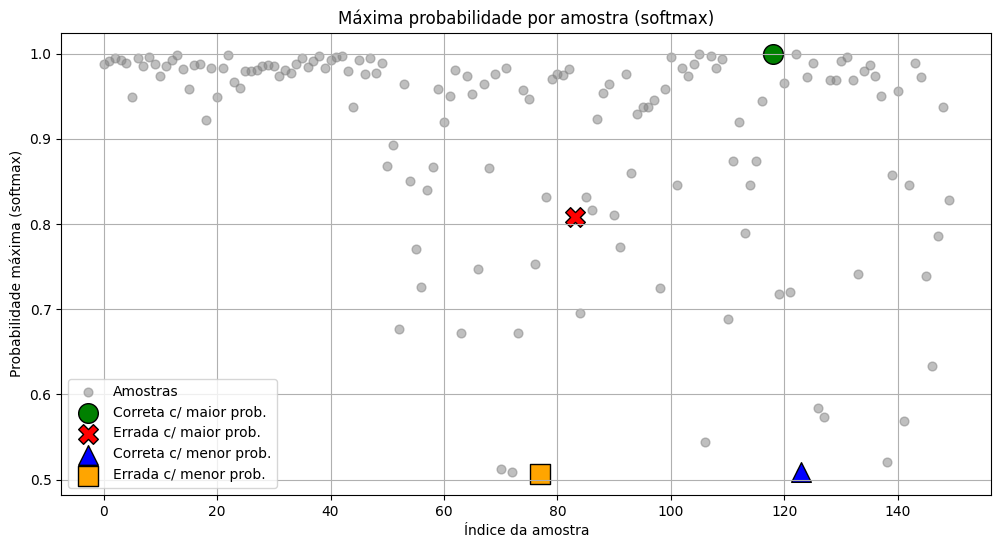

In [ ]:
# plotagem gráfico comparativo de máxima probabilidade
plt.figure(figsize=(12,6))

# Plota todas as probabilidades (pontos neutros)
plt.scatter(
    range(len(max_probs)),
    max_probs.detach().numpy(),
    color="gray",
    label="Amostras",
    s=40,
    alpha=0.5
)

# Destacar cada amostra especial

plt.scatter(sample1.item(), max_probs[sample1].item(),
            color="green", s=200, marker="o",
            edgecolor="black", label="Correta c/ maior prob.")

plt.scatter(sample2.item(), max_probs[sample2].item(),
            color="red", s=200, marker="X",
            edgecolor="black", label="Errada c/ maior prob.")

plt.scatter(sample3.item(), max_probs[sample3].item(),
            color="blue", s=200, marker="^",
            edgecolor="black", label="Correta c/ menor prob.")

plt.scatter(sample4.item(), max_probs[sample4].item(),
            color="orange", s=200, marker="s",
            edgecolor="black", label="Errada c/ menor prob.")

plt.title("Máxima probabilidade por amostra (softmax)")
plt.xlabel("Índice da amostra")
plt.ylabel("Probabilidade máxima (softmax)")
plt.grid(True)
plt.legend()
plt.show()

2 -

Se $$P_{total} = P_{densa} + P_{bias}$$

Onde:  Pt = número total de parâmetros, Pd = número de parâmetros camada densa, Pb = numero de bias


**Cálculo Número de Parâmetros Camada Densa:**

Dados:

**Nº de entradas** (features) = 4 (F)

**Nº de saídas** = 3 classes (S)

Logo:

$$P_{densa} = F \times S$$

$$P_{densa} = 12$$


**Cálculo Número Total de Parâmetros:**

$$P_{total} = 12 + 3$$
 $$P_{total} = 15$$


**Resultados:**

* **Nº de Pesos camada densa**: 12 parâmetros

* **Nº de Bias (vieses)**: 3 parâmetros

* **Nº Total de parâmetros**: 15 parâmetros


3- Temos **4 entradas**: sepal length, sepal width, petal length, petal width; e **3 saídas**: setosa, versicolor, virginica.

4- Com base na matriz de confusão presente no código:


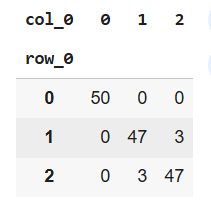

**Temos:**

**Nº de acertos** (diagonal principal):

   Nº de acertos = 50 + 47 + 47 = 144


**Nº total de amostras**:

   Nº total de amostras = 50 + 0 + 0 + 0 + 47 + 3 + 0 + 3 + 47 = 150


**Cáculo da Acurácia**:

$$\text{Acurácia} = \frac{144}{150} = \mathbf{0.96}$$

A acurácia do treinamento é de 96%.


5- Ela retorna 02 parâmetros. O *values* que retorna o tensor com os valores máximos encontrados numa dimensão especificada e o *indices* que retorna o tensor com os índices da primeira ocorrência de cada valor máximo na dimensão especificada. Estes índices representam a classe prevista.

## Principais aprendizados

No notebook aprendemos a regressão logística utilizando o dataset Iris, como é feita a preparação de dados, o treinamento do modelo, a interpretação das métricas, a análise dos erros, a visualização e interpretação dos resultados.